# Training of the LSTM NN

### Variables and functions definition

In [1]:
classes = ["yes", "no", "one", "two", "three", "four"] 
learning_rate = 7*1e-4 
epoch = 100 
batch_size = 64
validation_split = 0.1
dropout = 0.15
recurrent_dropout = 0.15
n_mel = 20 
n_mfcc = 5  


param_grid = {"model__learning_rate": [2*1e-4,5*1e-4,7*1e-4,1e-3],
                "model__dropout": [0.15, 0.35, 0.5],
                "model__recurrent_dropout": [0.15, 0.35, 0.5]}


In [2]:
import os
import pandas as pd
from pickle import load
import numpy as np

def load_and_padding(path, n_mfcc):
    """
    Loads the data from the pickle file and pad the signals to the same length.
    
    Parameters
    ----------
        path: path to the pickle file
        n_mfcc: number of mfcc features
    Returns
    -------
        x: padded mfcc features
        y: labels
        max_length: the length of the longest signal
        X_mask: a mask array to store the length of each padded signal
    """
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)

    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask


In [1]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
def create_train_test(file_path,n_mels,n_mfcc,classes,test_size=0.1,random_state=42): 
    '''
    Creates train and test sets from the data in the file_path

    Parameters
    ----------
        file_path: path to the pickle file
        n_mels: number of mel features
        n_mfcc: number of mfcc features
        classes: list of classes
        test_size: size of the test set
        random_state: random state for the train_test_split function
    Returns
    -------
        X_train: train set
        X_test: test set
        y_train: train labels
        y_test: test labels
        max_length: the length of the longest signal
        num_classes: number of classes
        classes: list of classes
    '''  
    X, y, max_length, X_mask = load_and_padding(file_path, n_mfcc=n_mfcc)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=test_size, random_state=random_state)
    num_classes = len(classes)
    y_train = [classes.index(x) for x in y_train]
    y_train = to_categorical(y_train, num_classes)
    y_test = [classes.index(x) for x in y_test]
    y_test = to_categorical(y_test, num_classes)
    return X_train, X_test, y_train, y_test, max_length, num_classes, classes

In [4]:
from keras.layers import Masking, LSTM, Dense
from keras.models import Sequential
from keras.optimizers import Adam

def create_model(learning_rate, dropout, recurrent_dropout,n_mfcc,max_length,num_classes,n_units=128):
        '''
        Creates the model. The model is a LSTM with 128 units and a softmax layer with num_classes units

        Parameters
        ----------
                learning_rate: learning rate for the Adam optimizer
                dropout: dropout rate for the LSTM layer
                recurrent_dropout: recurrent dropout rate for the LSTM layer
                n_mfcc: number of mfcc features
                max_length: the length of the longest signal
                num_classes: number of classes
                n_units: number of units in the LSTM layer, default

        Returns
        -------
                model: the model
        '''
        model = Sequential()
        model.add(Masking(mask_value=False, input_shape=(n_mfcc, max_length)))
        model.add(LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate), metrics=['accuracy'])
        return model

In [2]:
import audiofile
import scipy.signal as sps
import librosa

def load_from_wav(filePath):
    '''
    Loads the audio from the wav file. The audio is converted to mono and resampled to 20050 Hz

    Parameters
    ----------
        filePath: path to the wav file

    Returns
    -------
        arr: numpy array with the audio
        sr: sample rate
    '''
    audio, sr = librosa.load(filePath)
    arr = np.array(audio, dtype=float)
    return arr, sr


def process_audio(file_path, max_length, n_mels=20, n_mfcc=5):
    '''
    Processes the audio from the wav file. The audio is transformed to a mel spectrogram and then to mfcc

    Parameters
    ----------
        file_path: path to the wav file
        max_length: the length of the longest signal
        n_mels: number of mel features
        n_mfcc: number of mfcc features

    Returns
    -------
        x: numpy array with the processed audio
    '''
    y, sr = load_from_wav(file_path)
    S = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
    mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
    x = np.empty((1, n_mfcc, max_length))
    for i in range(len(mfcc)):
        x[0][i] = np.pad(mfcc[i], (0, max_length - len(mfcc[i])))
    return x


def predict(filePath, classes, model, max_length, n_mels=20, n_mfcc=5):
    '''
    Predicts the class of the audio in the file_path

    Parameters
    ----------
        filePath: path to the wav file
        classes: list of classes
        model: the model
        max_length: the length of the longest signal
        n_mels: number of mel features
        n_mfcc: number of mfcc features

    Returns
    -------
        prediction: the predicted class
    '''
    res = process_audio(filePath, max_length=max_length, n_mels=n_mels, n_mfcc=n_mfcc)
    pred = model.predict(res)
    prediction = classes[np.argmax(pred)]
    return prediction

In [7]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping


callback = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True,verbose=1)

def create_halving_gridsearch(param_grid,model_function=create_model, cv=2, factor=2, n_jobs=-1, verbose=1, validation_split=0.1, epoch=100, batch_size=124, callback=None, min_resources=700, max_resources=1000):
    '''
    Creates the grid search for the hyperparameter tuning

    Parameters
    ----------
        model: the model
        param_grid: the parameters to be tuned
        cv: number of folds for the cross validation
        factor: factor for the halving grid search
        n_jobs: number of jobs to run in parallel
        verbose: verbosity mode
        validation_split: validation split for the training
        epoch: number of epochs for the training
        batch_size: batch size for the training
        callback: callback for the training
        min_resources: minimum number of resources for the training
        max_resources: maximum number of resources for the training

    Returns
    -------
        grid: the grid search 
    '''
    model = KerasClassifier(model=model_function, epochs=epoch, batch_size=batch_size, validation_split=validation_split,callbacks=[callback],loss='categorical_crossentropy',verbose=1)
    # Creating the grid search
    grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid,cv=cv, n_jobs=n_jobs, verbose=verbose, factor=factor, min_resources=min_resources, max_resources=max_resources, scoring='accuracy', random_state=42)
    return grid

# Fine-tuning the hyperparameters

## Testing with different n_mels and m_fcc

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

callback = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True,verbose=1)

n_mels_list = [10,20]
n_mfcc_list = [3,4,5,7]


classes = ["yes", "no", "one", "two", "three", "four"] 
learning_rate = 6*1e-4 
epoch = 40 
batch_size = 128
validation_split = 0.1
dropout = 0.15
recurrent_dropout = 0.15

histories = []
test_accuracies = []
for n_mels in n_mels_list:
    for n_mfcc in n_mfcc_list:
        print("starting : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/8k_train_"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl",n_mels,n_mfcc,classes=classes,test_size=0.7)
        model = create_model(learning_rate, dropout,
                             recurrent_dropout, n_mfcc, max_length, num_classes)
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split, use_multiprocessing=True, callbacks=[callback])
        histories.append(history)
        print("finished : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print("Test accuracy of model with {} recurrent_dropout: {:.4f}".format(recurrent_dropout, test_acc))
        test_accuracies.append(test_acc)


starting : 10mels_3mfcc.pkl
Epoch 1/40
30/30 [==============================] - 8s 74ms/step - loss: 1.8239 - accuracy: 0.1964 - val_loss: 1.7477 - val_accuracy: 0.2422
Epoch 2/40
30/30 [==============================] - 1s 45ms/step - loss: 1.6775 - accuracy: 0.3070 - val_loss: 1.6666 - val_accuracy: 0.3189
Epoch 3/40
30/30 [==============================] - 1s 45ms/step - loss: 1.5889 - accuracy: 0.3805 - val_loss: 1.5928 - val_accuracy: 0.3309
Epoch 4/40
30/30 [==============================] - 2s 53ms/step - loss: 1.5059 - accuracy: 0.4274 - val_loss: 1.5710 - val_accuracy: 0.3717
Epoch 5/40
30/30 [==============================] - 1s 45ms/step - loss: 1.4400 - accuracy: 0.4652 - val_loss: 1.5439 - val_accuracy: 0.3693
Epoch 6/40
30/30 [==============================] - 1s 46ms/step - loss: 1.3944 - accuracy: 0.4908 - val_loss: 1.5131 - val_accuracy: 0.3909
Epoch 7/40
30/30 [==============================] - 1s 45ms/step - loss: 1.3419 - accuracy: 0.5063 - val_loss: 1.4639 - val_ac

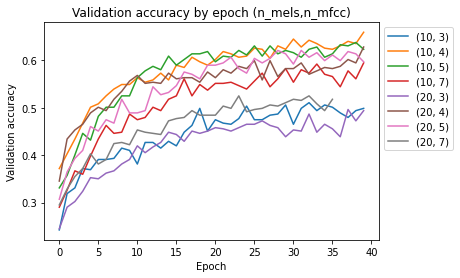

In [ ]:
import matplotlib.pyplot as plt
plt.figure()

labels = []
for n_mels in n_mels_list:
    for n_mfcc in n_mfcc_list:
        labels.append((n_mels,n_mfcc))
for i in range(len(histories)):
    plt.plot(histories[i].history["val_accuracy"])
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Validation accuracy by epoch (n_mels,n_mfcc)")
plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.show()

##   Grid search for learning rate, dropout and recurrent dropout


In [30]:

epoch = 100
batch_size = 128
n_mels = 10
n_mfcc = 4



# Creating an early stopping callback
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,verbose=1)
X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/8k_train_10mels_4mfcc.pkl",n_mels,n_mfcc,classes=classes)

param_grid = {"model__learning_rate": [8*1e-4, 8.5*1e-4,9*1e-4],
              "model__dropout": [0.16,0.18],
              "model__recurrent_dropout": [0.16,0.18],
              "model__n_units": [256],
              "model__n_mfcc": [n_mfcc],
              "model__max_length": [max_length],
              "model__num_classes": [num_classes]}

grid = create_halving_gridsearch(param_grid=param_grid,model_function=create_model, cv=2, factor=2, n_jobs=-1, verbose=1, validation_split=0.2, epoch=50, batch_size=124, callback=callback, min_resources=1000, max_resources=8000)
grid_result = grid.fit(X_train, y_train)

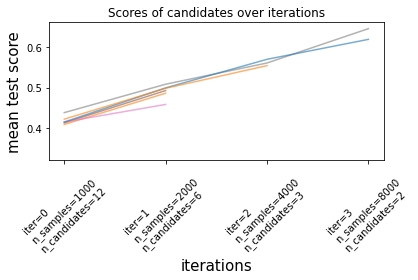

In [20]:
results = pd.DataFrame(grid_result.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_result.n_resources_[i]}\nn_candidates={grid_result.n_candidates_[i]}"
    for i in range(grid_result.n_iterations_)
]

ax.set_xticks(range(grid_result.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [34]:
results.to_csv("gridSrch_8k_1.csv")
grid_result.best_params_

grid_result.best_estimator_.score(X_test, y_test)

12/12 [==============================] - 0s 19ms/step


0.7052480230050323

# Evaluating a prediction

# Training the final model


In [37]:
from pickle import load
import numpy as np
import tensorflow as tf

classes = ["yes", "no", "one", "two", "three", "four"]


X_train, X_test, y_train, y_test, max_length, num_classes, classes = create_train_test("../assets/MFCCs/8k_train_10mels_4mfcc.pkl",10,4,classes)

epoch = 100
batch_size = 32
validation_split = 0.1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True,verbose=1)

model = create_model(learning_rate=8*1e-4,dropout=0.18,recurrent_dropout=0.18,max_length=max_length,num_classes=num_classes,n_mfcc=4)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_12 (Masking)        (None, 4, 581)            0         
                                                                 
 lstm_12 (LSTM)              (None, 128)               363520    
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
Total params: 364,294
Trainable params: 364,294
Non-trainable params: 0
_________________________________________________________________


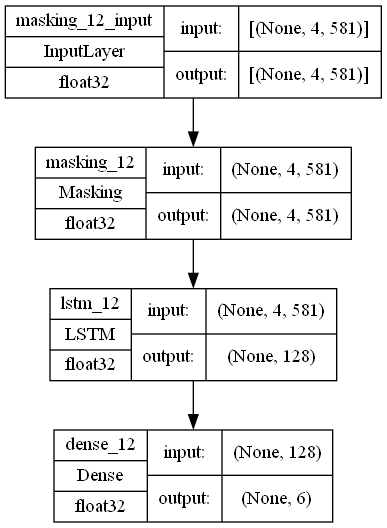

In [44]:
import keras.utils

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [38]:
model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split,callbacks=[callback],verbose=1)

Epoch 1/100
352/352 [==============================] - 10s 19ms/step - loss: 1.5614 - accuracy: 0.3634 - val_loss: 1.3571 - val_accuracy: 0.4948
Epoch 2/100
352/352 [==============================] - 6s 18ms/step - loss: 1.2942 - accuracy: 0.5031 - val_loss: 1.2083 - val_accuracy: 0.5340
Epoch 3/100
352/352 [==============================] - 6s 18ms/step - loss: 1.1756 - accuracy: 0.5555 - val_loss: 1.1531 - val_accuracy: 0.5572
Epoch 4/100
352/352 [==============================] - 6s 18ms/step - loss: 1.0832 - accuracy: 0.5934 - val_loss: 1.0687 - val_accuracy: 0.6003
Epoch 5/100
352/352 [==============================] - 6s 18ms/step - loss: 0.9962 - accuracy: 0.6303 - val_loss: 1.0467 - val_accuracy: 0.6211
Epoch 6/100
352/352 [==============================] - 6s 18ms/step - loss: 0.9629 - accuracy: 0.6430 - val_loss: 1.0089 - val_accuracy: 0.6147
Epoch 7/100
352/352 [==============================] - 6s 18ms/step - loss: 0.9192 - accuracy: 0.6621 - val_loss: 0.9976 - val_accuracy

In [40]:
model.save("lstm_20_5_8k_opti.h5")


In [39]:
model.evaluate(X_test, y_test)


44/44 [==============================] - 0s 7ms/step - loss: 1.0118 - accuracy: 0.6226


[1.0118408203125, 0.6225736737251282]

# Display the confusion matrix

44/44 [==============================] - 1s 7ms/step


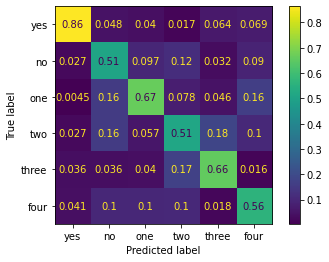

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model

model = load_model("lstm_20_5_8k_opti.h5")
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction,axis=1)
# y_test = np.argmax(y_test,axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y_test,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

# Predict correct label

In [ ]:
from keras.models import load_model


classes = ["yes", "no", "one", "two", "three", "four"]
n_mel = 20
n_mfcc = 13
max_length = 422





print(predict_result_lstm("./sounds/yes_1675445508552.wav",
      classes, "lstm_20_5",422))


# Add my personal database


In [ ]:
import pandas as pd

df = pd.read_csv("./sounds/rahim/rahim.csv", sep=";")


,file,sentence
0,one (2).wav,one
1,one (3).wav,one
2,one (4).wav,one
3,one (5).wav,one
4,one (6).wav,one
...,...,...
75,four (17).wav,four
76,four (18).wav,four
77,four (19).wav,four
78,four (20).wav,four


5/5 [==============================] - 0s 7ms/step


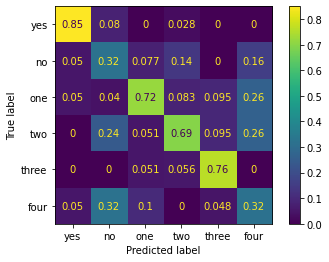

In [45]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
from pickle import *
import numpy as np

classes = ["yes", "no", "one", "two", "three", "four"]


def load_and_padding(path,max_length, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)

    # max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

def create_test(file_path,n_mels,n_mfcc,classes): 
    '''Creates train and test sets from the data in the file_path.'''  
    X, y, max_length, X_mask = load_and_padding(file_path,581, n_mfcc=n_mfcc)
    num_classes = len(classes)
    y = [classes.index(x) for x in y]
    y = to_categorical(y, num_classes)
    return X, y, max_length, num_classes, classes

X, y, max_length, num_classes, classes = create_test("../assets/MFCCs/rahim_mfcc_10_4.pkl",10,4,classes)
y_prediction = model.predict(X)
y_prediction = np.argmax(y_prediction,axis=1)

# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

# Training model for yes or no 

### Yes No LSTM Model Train

### Load

In [47]:
import os
import pandas as pd
from pickle import *
import numpy as np

classes = ["yes", "no"]
#16k_train_20mels_5mfcc.pkl
with open("../assets/MFCCs/8k_train_10mels_4mfcc.pkl", "rb") as f:
    X = load(f)
    y = load(f)



### X and y with yes and no

In [57]:
y = np.array(y)

indices_yes_no = np.where(((y == 'no') | (y == 'yes')) )
X_yes_no = [X[i] for i in indices_yes_no[0]]
y_yes_no = [y[i] for i in indices_yes_no[0]]
# print(len(X_yes_no))
# print(len(y_yes_no))



4868
4868


### On va modifier la fonction pour le prendre en compte

In [58]:
def load_and_padding_yes_no(path, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)
    y = np.array(y)
    
    indices_yes_no = np.where(((y == 'no') | (y == 'yes')) )
    X = [X[i] for i in indices_yes_no[0]]
    y = [y[i] for i in indices_yes_no[0]]


    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

In [71]:
path = "../assets/MFCCs/8k_train_10mels_4mfcc.pkl"
n_mfcc = 4
X, y, max_length, X_mask = load_and_padding_yes_no(path, n_mfcc)


In [70]:
print(y)

TypeError: 'int' object is not subscriptable

### Splitting data

In [72]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical

# Load the data into a pandas DataFrame
import pandas as pd

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=42)

In [73]:
num_classes=len(classes)
y_train = [classes.index(x) for x in y_train]
y_train = to_categorical(y_train, num_classes)
y_test = [classes.index(x) for x in y_test]
y_test = to_categorical(y_test, num_classes)

### Training the model with the selected hyperparameters

In [85]:
learning_rate = 6*1e-4
epoch = 100
batch_size = 16
validation_split = 0.1
dropout = 0.185
recurrent_dropout = 0.185
histories = []
test_accuracies = []

model = create_model(learning_rate, dropout,recurrent_dropout,4, max_length, num_classes=2)

In [90]:
model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,validation_split=validation_split, use_multiprocessing=True, callbacks=[callback],verbose=1)

Epoch 1/100
247/247 [==============================] - 4s 16ms/step - loss: 0.1124 - accuracy: 0.9597 - val_loss: 0.2579 - val_accuracy: 0.9157
Epoch 2/100
247/247 [==============================] - 4s 16ms/step - loss: 0.1017 - accuracy: 0.9642 - val_loss: 0.2468 - val_accuracy: 0.9134
Epoch 3/100
247/247 [==============================] - 4s 16ms/step - loss: 0.1029 - accuracy: 0.9658 - val_loss: 0.2555 - val_accuracy: 0.9021
Epoch 4/100
247/247 [==============================] - 4s 15ms/step - loss: 0.0803 - accuracy: 0.9744 - val_loss: 0.2862 - val_accuracy: 0.8998
Epoch 5/100
247/247 [==============================] - 4s 16ms/step - loss: 0.0812 - accuracy: 0.9729 - val_loss: 0.2716 - val_accuracy: 0.9043
Epoch 6/100
247/247 [==============================] - 4s 16ms/step - loss: 0.0765 - accuracy: 0.9708 - val_loss: 0.2752 - val_accuracy: 0.9112
Epoch 7/100
247/247 [==============================] - 4s 16ms/step - loss: 0.0743 - accuracy: 0.9782 - val_loss: 0.2731 - val_accuracy:

In [ ]:
model.save("lstm_20_5_8k_opti_yes_no.h5")


In [91]:
model.evaluate(X_test, y_test)


16/16 [==============================] - 0s 10ms/step - loss: 0.2448 - accuracy: 0.8891


[0.24476349353790283, 0.8891170620918274]

16/16 [==============================] - 1s 10ms/step


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (6).

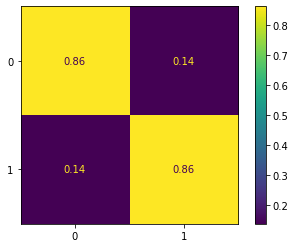

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model

model = load_model("lstm_10_4_8k_opti_yes_no.h5")
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction,axis=1)
# y_test = np.argmax(y_test,axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y_test,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

2/2 [==============================] - 0s 10ms/step


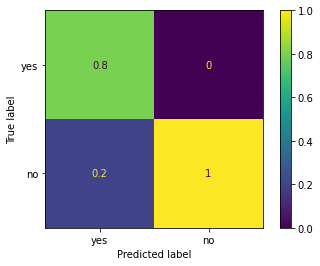

In [97]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
from pickle import *
import numpy as np

classes = ["yes", "no"]


def load_and_padding_yes_no(path,max_length, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)
    y = np.array(y)
    
    indices_yes_no = np.where(((y == 'no') | (y == 'yes')) )
    X = [X[i] for i in indices_yes_no[0]]
    y = [y[i] for i in indices_yes_no[0]]


    # max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

def create_test(file_path,n_mels,n_mfcc,classes): 
    '''Creates train and test sets from the data in the file_path.'''  
    X, y, max_length, X_mask = load_and_padding_yes_no(file_path,461, n_mfcc=n_mfcc)
    num_classes = len(classes)
    y = [classes.index(x) for x in y]
    y = to_categorical(y, num_classes)
    return X, y, max_length, num_classes, classes

X, y, max_length, num_classes, classes = create_test("../assets/MFCCs/rahim_mfcc_10_4.pkl",10,4,classes)
y_prediction = model.predict(X)
y_prediction = np.argmax(y_prediction,axis=1)

# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

# Training pour les numbers

In [111]:
def load_and_padding_one_four(path, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)
    y = np.array(y)
    
    indices_yes_no = np.where(((y == 'one') | (y == 'two') | (y == 'three') | (y == 'four')) )
    X = [X[i] for i in indices_yes_no[0]]
    y = [y[i] for i in indices_yes_no[0]]


    max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

In [112]:
path = "../assets/MFCCs/8k_train_20mels_5mfcc.pkl"
n_mfcc = 5
X, y, max_length, X_mask = load_and_padding_one_four(path, n_mfcc)


### Splitting data

In [113]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical

# Load the data into a pandas DataFrame
import pandas as pd

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=42)

In [114]:
classes = ["one", "two", "three", "four"]
num_classes=len(classes)
y_train = [classes.index(x) for x in y_train]
y_train = to_categorical(y_train, num_classes)
y_test = [classes.index(x) for x in y_test]
y_test = to_categorical(y_test, num_classes)

### Training the model with the selected hyperparameters

In [115]:
learning_rate = 7*1e-4
epoch = 100
batch_size = 32
validation_split = 0.1
dropout = 0.18
recurrent_dropout = 0.18
histories = []
test_accuracies = []

model = create_model(learning_rate, dropout,recurrent_dropout,5, max_length, num_classes=4)

In [116]:
model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,validation_split=validation_split, use_multiprocessing=True, callbacks=[callback],verbose=1)

Epoch 1/100
229/229 [==============================] - 11s 25ms/step - loss: 1.1942 - accuracy: 0.4515 - val_loss: 1.0498 - val_accuracy: 0.5400
Epoch 2/100
229/229 [==============================] - 5s 21ms/step - loss: 0.9737 - accuracy: 0.5968 - val_loss: 0.9574 - val_accuracy: 0.6212
Epoch 3/100
229/229 [==============================] - 5s 22ms/step - loss: 0.8543 - accuracy: 0.6640 - val_loss: 0.8876 - val_accuracy: 0.6408
Epoch 4/100
229/229 [==============================] - 5s 22ms/step - loss: 0.7639 - accuracy: 0.7065 - val_loss: 0.8200 - val_accuracy: 0.6593
Epoch 5/100
229/229 [==============================] - 5s 21ms/step - loss: 0.6879 - accuracy: 0.7388 - val_loss: 0.8133 - val_accuracy: 0.6507
Epoch 6/100
229/229 [==============================] - 5s 21ms/step - loss: 0.6327 - accuracy: 0.7579 - val_loss: 0.8121 - val_accuracy: 0.6876
Epoch 7/100
229/229 [==============================] - 5s 22ms/step - loss: 0.5954 - accuracy: 0.7794 - val_loss: 0.8093 - val_accuracy

In [117]:
model.save("lstm_20_5_8k_opti_one_four.h5")


In [119]:
max_length

581

In [118]:
model.evaluate(X_test, y_test)


29/29 [==============================] - 0s 8ms/step - loss: 0.8582 - accuracy: 0.7046


[0.8582158088684082, 0.7046459913253784]

29/29 [==============================] - 1s 8ms/step


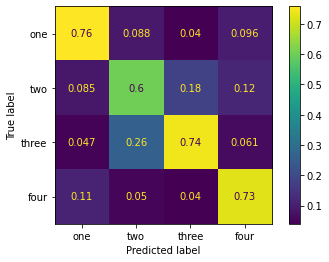

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model

model = load_model("lstm_20_5_8k_opti_one_four.h5")
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction,axis=1)
# y_test = np.argmax(y_test,axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y_test,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()

4/4 [==============================] - 0s 8ms/step


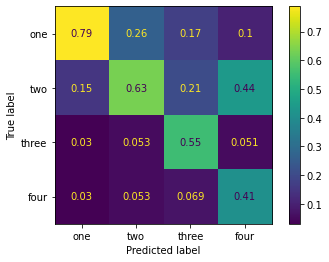

In [126]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
from pickle import *
import numpy as np

classes = ["one", "two", "three", "four"]


def load_and_padding_yes_no(path,max_length, n_mfcc):
    with open(path, "rb") as f:
        X = load(f)
        y = load(f)
    y = np.array(y)
    
    indices_yes_no = np.where(((y == 'one') | (y == 'two') | (y == 'three') | (y == 'four')) )
    X = [X[i] for i in indices_yes_no[0]]
    y = [y[i] for i in indices_yes_no[0]]


    # max_length = max([len(X[i][0]) for i in range(len(X))])
    x = np.empty((len(X), n_mfcc, max_length))
    for i in range(len(X)):
        for j in range(len(X[i])):
            x[i][j] = np.pad(X[i][j], (0, max_length - len(X[i][j])))
    x = np.array(x).reshape((-1, n_mfcc, max_length))
    
    # Create a mask array to store the length of each padded signal
    X_mask = np.zeros((x.shape[0], max_length), dtype=bool)
    for i in range(x.shape[0]):
        length = len(X[i][0])
        X_mask[i, :length] = True
    
    return x, y, max_length, X_mask

def create_test(file_path,n_mels,n_mfcc,classes): 
    '''Creates train and test sets from the data in the file_path.'''  
    X, y, max_length, X_mask = load_and_padding_yes_no(file_path,581, n_mfcc=n_mfcc)
    num_classes = len(classes)
    y = [classes.index(x) for x in y]
    y = to_categorical(y, num_classes)
    return X, y, max_length, num_classes, classes

X, y, max_length, num_classes, classes = create_test("../assets/MFCCs/rahim_mfcc.pkl",20,5,classes)
y_prediction = model.predict(X)
y_prediction = np.argmax(y_prediction,axis=1)

# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(np.argmax(y,axis=1), y_prediction, normalize='pred')
ConfusionMatrixDisplay(result, display_labels=classes).plot()